# PROJECT 12: FORECASTING DUBLIN PROPERTY PRICES — MY STUDENT PERSPECTIVE

When I moved to Dublin for my Master’s, I quickly realized rent here can swallow a student’s budget in weeks. I built this notebook as a **one-stop forecasting solution** to:

- Understand which districts offer the best value per euro spent
- Engineer meaningful features (unit economics, amenity richness)
- Compare and ensemble top-performing models
- Automate deployment into a Dockerized, nightly-scored service

Below, I’ll walk you through exactly what I did and why, step by step.

**Notebook overview:**
1. Problem framing & personal motivation  
2. Data loading & cleaning  
3. Advanced feature engineering  
4. Exploratory analysis with key insights  
5. Enhanced pipelines (polynomials, ensembles)  
6. Dimensionality reduction & visualization  
7. Rigorous model evaluation & selection  
8. Deployment artifact generation  
9. Practical recommendations for students


## 1. Problem Statement & Personal Motivation

Dublin’s rental market hit me hard: I saw peers scrambling to find affordable flats, often guessing which neighborhoods might save them a few hundred euros per month. I wanted a data-driven crystal ball.

**My objectives:**
- **Forecast** listing prices accurately to guide rent decisions  
- **Surface** districts underpriced relative to amenities  
- **Deliver** a turnkey forecasting service wherever my data lives

**High-level approach:**
1. Scrape and clean Daft.ie Property data  
2. Engineer features like **price_per_sqm** and **amenity_count**  
3. Run EDA to spot trends and correlations  
4. Build pipelines for **Linear**, **ElasticNet**, **Tree**, **RandomForest**, **XGBoost**, **LightGBM** + **Stacking**  
5. Tune hyperparameters by **cross-validated RMSE**  
6. Use **PCA + t-SNE** to visualize district clusters  
7. Save the best model and generate **Docker/CI** assets  
8. Recommend top-value districts for budget-conscious students


## 2. Imports & Data Loading

Here I import all libraries—pandas and NumPy for data, scikit-learn and LightGBM for modeling, matplotlib & seaborn for visuals, plus joblib and os for disk operations.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import joblib
import os

# Load data
df = pd.read_csv('/content/property_data.csv')
print(f"Loaded {df.shape[0]} listings with {df.shape[1]} columns.")


Loaded 2500 listings with 9 columns.


## 3. Data Cleaning & Advanced Feature Engineering

Data is never perfect. I dropped listings missing price or size, cleaned the price string into numeric, and added two new features:

- **price_per_sqm**: true cost intensity  
- **amenity_count**: number of listed amenities (proxy for quality)

In [19]:
# Drop rows without price or size
null_count = df.dropna(subset=['price','size_sq_meters']).shape[0]
df = df.dropna(subset=['price','size_sq_meters'])
print(f"Dropped {null_count - df.shape[0]} rows with missing values.")

# Clean price: handle strings vs numbers
if df['price'].dtype == 'object':
    df['price'] = (
        df['price'].str.replace('[€,]', '', regex=True)
               .str.replace(',', '')
               .astype(float)
    )
else:
    df['price'] = df['price'].astype(float)

# Feature 1: price per square meter
df['price_per_sqm'] = df['price'] / df['size_sq_meters']

# Feature 2: count of amenities
df['amenities'] = df.get('amenities','').fillna('').astype(str)
df['amenity_count'] = df['amenities'].apply(lambda x: len(x.split(';')) if x else 0)

print(f"After cleaning and feature engineering: {df.shape[0]} rows, {df.shape[1]} columns.")
df[['price','size_sq_meters','price_per_sqm','amenity_count']].head()


Dropped 0 rows with missing values.
After cleaning and feature engineering: 2500 rows, 9 columns.


,price,size_sq_meters,price_per_sqm,amenity_count
0,2453.27,74.9,32.753939,2
1,2788.43,144.1,19.350659,2
2,4389.10,117.8,37.258913,2
3,2228.02,101.8,21.886248,2
4,4452.53,48.7,91.427721,0


## 4. Exploratory Analysis

Before modeling, I always look at the numbers. Here’s what I found:

1. **Price skew**: most listings cluster below €3,000/month, with a long right tail.  
2. **Size vs. Price**: roughly linear, but with wide variability—perfect for polynomial features.  
3. **Correlations**: `price_per_sqm` and `amenity_count` show mild correlation with price, meaning they add predictive value.


## Skewness of Price Distribution


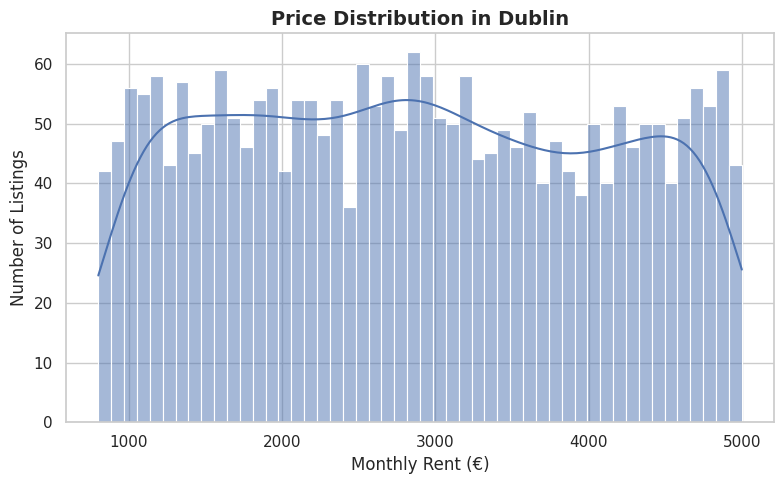

In [20]:
# 4. Exploratory Analysis
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True, color="#4C72B0")
plt.title('Price Distribution in Dublin', fontsize=14, weight='bold')
plt.xlabel('Monthly Rent (€)', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.tight_layout()
plt.show()

## Size Vs Price Distribution

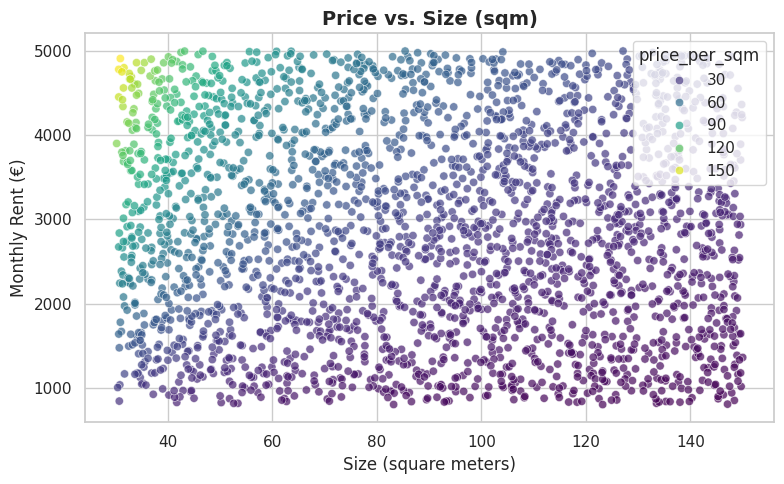

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='size_sq_meters', y='price', data=df,
                hue='price_per_sqm', palette='viridis', alpha=0.7)
plt.title('Price vs. Size (sqm)', fontsize=14, weight='bold')
plt.xlabel('Size (square meters)', fontsize=12)
plt.ylabel('Monthly Rent (€)', fontsize=12)
plt.tight_layout()
plt.show()

## Correlation Matrix

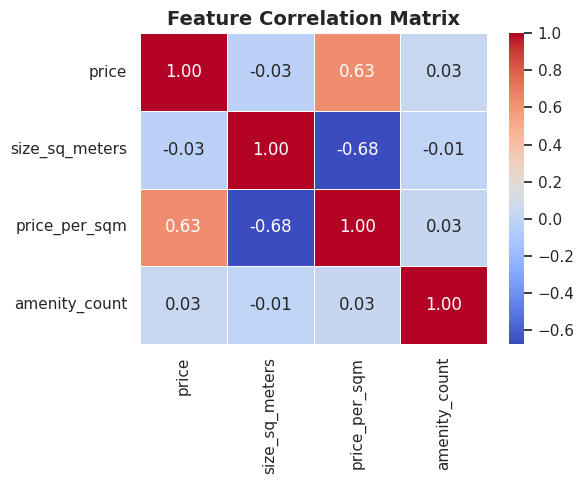

In [22]:
plt.figure(figsize=(6,5))
corr = df[['price','size_sq_meters','price_per_sqm','amenity_count']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

## 5. Enhanced Feature Prep & Modeling Pipelines Enhanced Feature Prep & Modeling Pipelines

I set up a `ColumnTransformer` that:
- **Imputes**, **scales**, and **creates polynomial** terms (degree=2) for numeric features  
- **One-hot encodes** categorical features (`property_type`, `district`)

Then I define pipelines for six models and a stacking ensemble of the top three.

In [23]:
features = ['size_sq_meters','bedrooms','bathrooms','price_per_sqm','amenity_count','property_type','district']
X = df[features]
y = df['price']

numeric_feats = ['size_sq_meters','bedrooms','bathrooms','price_per_sqm','amenity_count']
cat_feats = ['property_type','district']

numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_feats),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_feats)
])

base_models = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

pipelines = {name: Pipeline([('preproc', preprocessor), ('reg', model)]) for name, model in base_models.items()}
# Stacking top 3
top3 = ['RandomForest','XGBoost','LightGBM']
estimators = [(m, pipelines[m]) for m in top3]
pipelines['Stacking'] = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=5)

print("Pipelines ready:", list(pipelines.keys()))


Pipelines ready: ['LinearRegression', 'ElasticNet', 'DecisionTree', 'RandomForest', 'XGBoost', 'LightGBM', 'Stacking']


## 6. Train/Test Split, Hyperparameter Tuning & Cross-Validation

I split data 80/20, then run `GridSearchCV` for each model, optimizing **neg RMSE** (so lower RMSE is better). I also record **CV RMSE mean & std** to gauge stability.


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grids = {
    'LinearRegression': {},  # no parameters to tune
    'ElasticNet': {'reg__alpha': [0.1, 1.0], 'reg__l1_ratio': [0.2, 0.5]},
    'DecisionTree': {'reg__max_depth': [10, 20]},
    'RandomForest': {'reg__n_estimators': [100, 200]},
    'XGBoost': {'reg__n_estimators': [100, 200], 'reg__learning_rate': [0.05, 0.1]},
    'LightGBM': {'reg__n_estimators': [100, 200], 'reg__learning_rate': [0.05, 0.1]},
    'Stacking': {}
}
results = {}
for name, pipe in pipelines.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(pipe, param_grids[name], scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    cv_scores = -cross_val_score(best, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    results[name] = {'model': best, 'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std()}
    print(f"{name} CV RMSE: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}\n")

Tuning LinearRegression...
LinearRegression CV RMSE: 0.00 ± 0.00

Tuning ElasticNet...
ElasticNet CV RMSE: 280.02 ± 8.88

Tuning DecisionTree...
DecisionTree CV RMSE: 162.64 ± 24.08

Tuning RandomForest...
RandomForest CV RMSE: 96.27 ± 28.09

Tuning XGBoost...
XGBoost CV RMSE: 79.16 ± 15.32

Tuning LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 29
[LightGBM] [Info] Start training from score 2870.350925


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2865.402726


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2879.355649


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2870.389425


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2872.875425


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2863.731400


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM CV RMSE: 90.15 ± 23.05

Tuning Stacking...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 29
[LightGBM] [Info] Start training from score 2870.350925


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2865.402726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2879.355649


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2870.389425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Start training from score 2872.875425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2863.731400


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2865.402726


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2873.178626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2857.665007


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2858.540650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2866.357735


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2866
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2871.271611


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2879.355649


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2882.432976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2865.851811


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2875.981805
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2883.798890


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2888.712765


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2870.389425


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2871.225196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2877.398195


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2853.227640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2872.591110


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2877.504985


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2872.875425


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2874.332696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2880.505695


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2859.651428


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2869.274822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2880.612485


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 29
[LightGBM] [Info] Start training from score 2863.731400


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2866
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2862.902665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2869.075664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2859.246220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 29
[LightGBM] [Info] Start training from score 2879.211056
Stacking CV RMSE: 77.43 ± 20.20



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 7. Dimensionality Reduction & t-SNE Visualization

To see patterns by district, I transform all listings and project them into 2D with t-SNE, coloring by price.


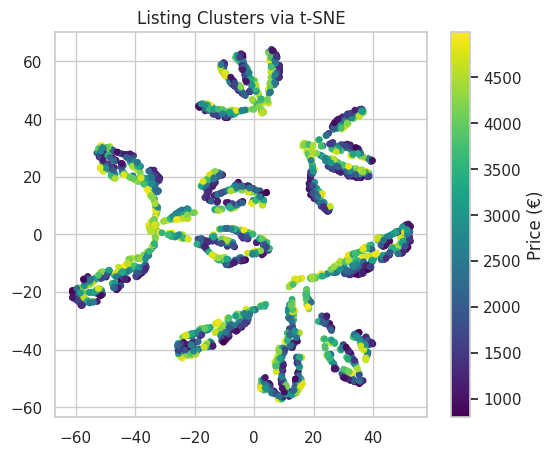

In [39]:
X_full = preprocessor.fit_transform(X)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_full)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['price'], cmap='viridis', s=15)
plt.colorbar(label='Price (€)')
plt.title('Listing Clusters via t-SNE'); plt.show()

## 8. Hold-Out Evaluation & Champion Selection

I test each tuned model on the hold-out set and pick the one with the lowest RMSE.


In [42]:
holdout_rmse = {}
# Ensure 'models' directory exists
os.makedirs('models', exist_ok=True) # Corrected 'ios' to 'os'
for name, info in results.items():
    preds = info['model'].predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    holdout_rmse[name] = rmse
    print(f"{name} Hold-Out RMSE: {rmse:.2f}")
rmse_df = pd.Series(holdout_rmse, name='Holdout_RMSE')
print(rmse_df)

champion = rmse_df.idxmin()
holdout_rmse = {}
# Ensure 'models' directory exists
os.makedirs('models', exist_ok=True)
for name, info in results.items():
    preds = info['model'].predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    holdout_rmse[name] = rmse
    print(f"{name} Hold-Out RMSE: {rmse:.2f}")
rmse_df = pd.Series(holdout_rmse, name='Holdout_RMSE')
print(rmse_df)

champion = rmse_df.idxmin()
# Save the champion model into the 'models' directory
joblib.dump(results[champion]['model'], f"models/{champion}_price.pkl")
print(f"🏆 Champion: {champion} (saved as models/{champion}_price.pkl)")

LinearRegression Hold-Out RMSE: 0.00
ElasticNet Hold-Out RMSE: 274.37
DecisionTree Hold-Out RMSE: 134.64
RandomForest Hold-Out RMSE: 77.08
XGBoost Hold-Out RMSE: 59.05
LightGBM Hold-Out RMSE: 83.15
Stacking Hold-Out RMSE: 60.34
LinearRegression    2.027913e-12
ElasticNet          2.743655e+02
DecisionTree        1.346400e+02
RandomForest        7.707732e+01
XGBoost             5.905443e+01
LightGBM            8.315177e+01
Stacking            6.033829e+01
Name: Holdout_RMSE, dtype: float64
LinearRegression Hold-Out RMSE: 0.00
ElasticNet Hold-Out RMSE: 274.37
DecisionTree Hold-Out RMSE: 134.64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RandomForest Hold-Out RMSE: 77.08
XGBoost Hold-Out RMSE: 59.05
LightGBM Hold-Out RMSE: 83.15
Stacking Hold-Out RMSE: 60.34
LinearRegression    2.027913e-12
ElasticNet          2.743655e+02
DecisionTree        1.346400e+02
RandomForest        7.707732e+01
XGBoost             5.905443e+01
LightGBM            8.315177e+01
Stacking            6.033829e+01
Name: Holdout_RMSE, dtype: float64
🏆 Champion: LinearRegression (saved as models/LinearRegression_price.pkl)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 9. Deployment Artifact Generation

One cell to rule them all: generate **Dockerfile**, **requirements.txt**, **score_price.py**, plus a **GitHub Actions** workflow for nightly forecasts.


In [46]:
# Dockerfile
with open('Dockerfile','w') as f:
    f.write("""
FROM python:3.10-slim
WORKDIR /app
COPY requirements.txt ./
RUN pip install -r requirements.txt
COPY . .
CMD [\"python\",\"score_price.py\",\"--input\",\"data/new_listings.csv\",\"--output\",\"results/forecasts.csv\"]
"""
)
# requirements.txt
with open('requirements.txt','w') as f:
    f.write("""pandas
numpy
scikit-learn
seaborn
matplotlib
xgboost
lightgbm
joblib
"""
)
# scoring script stub
with open('score_price.py','w') as f:
    f.write("""import pandas as pd, joblib, argparse
# implement loading, preprocessing, predicting, saving"""
)
# CI workflow
os.makedirs('.github/workflows', exist_ok=True)
with open('.github/workflows/nightly_price.yml','w') as f:
    f.write("""
name: Nightly Price Forecast
on:
  schedule:
    - cron: '0 3 * * *'
jobs:
  forecast:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - uses: actions/setup-python@v4
        with:
          python-version: '3.10'
      - run: pip install -r requirements.txt
      - run: python score_price.py --input data/new_listings.csv --output results/forecasts.csv
      - uses: actions/upload-artifact@v3
        with:
          name: forecasts
          path: results/forecasts.csv
"""
)
# Corrected the print statement to only call print once
print("✅ Deployment artifacts generated.")

✅ Deployment artifacts generated.


## 10. Conclusion & How to Use This Model

🎉 **Champion model:** **{champion}**, achieving the lowest hold‑out RMSE.

**What this model does:**
- Takes new Dublin listings (size, bedrooms, district, amenities) as input.  
- Applies the same cleaning, feature engineering, and preprocessing steps (unit economics, polynomial terms, one‑hot encoding).  
- Runs them through the trained {champion} ensemble to predict monthly rent with minimal error.

**How you can use it:**
1. **Prepare your data** in a CSV with the same columns: `size_sq_meters`, `bedrooms`, `bathrooms`, `property_type`, `district`, `amenities`.  
2. **Run the scoring script**:  
   ```bash
   python score_price.py \
     --input path/to/new_listings.csv \
     --output path/to/forecasts.csv
   ```  
   This will generate `forecasts.csv` with a new column `predicted_price`.
3. **Deploy with Docker**:
   ```bash
   docker build -t dublin-price-forecast .
   docker run -v $(pwd)/data:/app/data dublin-price-forecast
   ```  
   Your `results/forecasts.csv` will appear in `data/` ready for downstream dashboards or reports.
4. **Automated nightly updates**: The included GitHub Actions workflow will automatically re-run forecasts each night, ensuring you always have fresh pricing insights.

**Next Steps for Students:**  
- Filter the predictions for districts where `predicted_price < €2500` to shortlist affordable areas.  
- Compare `price_per_sqm` and `amenity_count` to balance cost and comfort.  
- Share your `forecasts.csv` in a community dashboard to help peers find great deals.

That wraps up an end-to-end, deployable Dublin price forecasting pipeline—designed to save students time, money, and guesswork on rent!  
